In [1]:
## Here we go again

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from scipy.stats import linregress


In [3]:
# Load the datasets
train_data = pd.read_csv('C://Users//Hp//Documents//WIDs//train.csv')
test_data = pd.read_csv('C://Users//Hp//Documents//WIDs//test.csv')
solution_data= pd.read_csv('C://Users//Hp//Documents//WIDs//solution_template.csv')

In [4]:
#print train head
train_data.head(5)

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,...,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
0,268700,NaN,COMMERCIAL,AR,724,South,West South Central,39,F,NaN,...,52.55,74.77,79.96,81.69,78.30,74.56,59.98,42.98,41.18,191
1,484983,White,NaN,IL,629,Midwest,East North Central,55,F,35.36,...,49.30,72.87,77.40,77.43,75.83,72.64,58.36,39.68,39.71,33
2,277055,NaN,COMMERCIAL,CA,925,West,Pacific,59,F,NaN,...,68.50,70.31,78.61,87.24,85.52,80.75,70.81,62.67,55.58,157
3,320055,Hispanic,MEDICAID,CA,900,West,Pacific,59,F,NaN,...,63.34,63.10,67.45,75.86,75.24,71.10,68.95,65.46,59.46,146
4,190386,NaN,COMMERCIAL,CA,934,West,Pacific,71,F,NaN,...,59.45,60.24,64.77,69.81,70.13,68.10,65.38,60.72,54.08,286


In [5]:
#print test head
test_data.head(5)

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,...,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18
0,730681,NaN,COMMERCIAL,LA,713,South,West South Central,55,F,NaN,...,62.21,62.23,78.34,81.96,83.58,82.22,80.20,69.73,53.14,51.34
1,334212,Black,NaN,NC,283,South,South Atlantic,60,F,40.00,...,48.63,58.14,77.26,80.05,82.88,82.09,78.85,64.60,50.57,48.10
2,571362,NaN,COMMERCIAL,TX,794,South,West South Central,54,F,32.33,...,57.82,59.95,77.79,82.45,82.44,80.77,72.16,59.31,48.25,42.13
3,907331,NaN,COMMERCIAL,TN,373,South,East South Central,63,F,27.07,...,47.57,53.50,71.31,75.20,76.96,75.78,74.87,61.06,44.31,42.83
4,208382,Asian,NaN,WA,980,West,Pacific,62,F,NaN,...,41.02,46.25,56.92,57.88,66.16,65.21,57.52,49.53,43.75,38.33


In [6]:
#print solution head
solution_data.head(5)

,patient_id,metastatic_diagnosis_period
0,730681,100
1,334212,0
2,571362,100
3,907331,100
4,208382,100


In [7]:
## Data pre-processing 

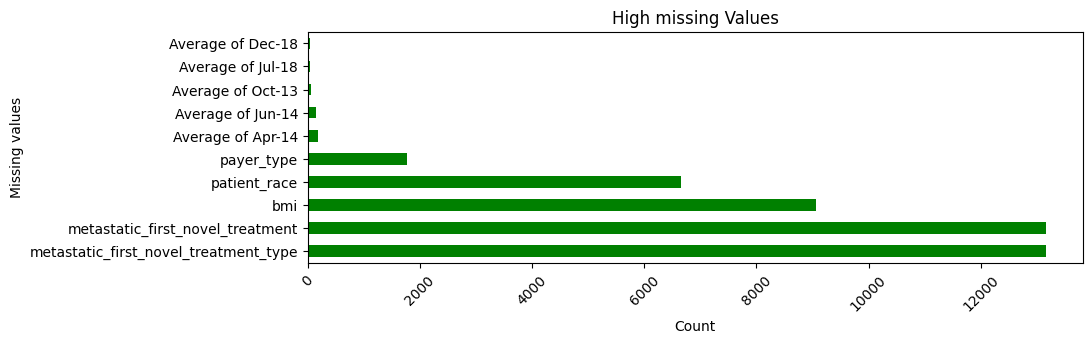

In [8]:
# missing values
plt.figure(figsize = (10,3))
missing_values =  train_data.isna().sum().sort_values(ascending=False)
missing_values.head(10).plot(kind='barh',color='green')
plt.title('High missing Values')
plt.xlabel('Count')
plt.xticks(rotation = 45)
plt.ylabel('Missing values')
plt.show()

In [9]:
# Drop columns from above
train_data = train_data.drop(['metastatic_first_novel_treatment_type','metastatic_first_novel_treatment'], axis=1)
test_data = test_data.drop(['metastatic_first_novel_treatment_type','metastatic_first_novel_treatment'], axis=1)

In [10]:
# Categorize Age
train_data['patient_age'] = pd.cut(train_data['patient_age'], right=False, bins=[0,30,40,50,60,70,80,90,np.inf], labels=[0,1,2,3,4,5,6,7])

In [11]:
train_data['patient_age']

0        1
1        3
2        3
3        3
4        5
        ..
13168    3
13169    5
13170    0
13171    3
13172    4
Name: patient_age, Length: 13173, dtype: category
Categories (8, int64): [0 < 1 < 2 < 3 < 4 < 5 < 6 < 7]

In [12]:
# Filling nulls by deriving values from other features
def replace_race(df):
    max_race_zip = df.groupby('patient_zip3')['patient_race'].agg(lambda x:x.mode().iloc[0] if not x.mode().empty else None)
    max_race_state = df.groupby('patient_state')['patient_race'].agg(lambda x:x.mode().iloc[0] if not x.mode().empty else None) 
    
    df['patient_race'] = df.apply(lambda row: max_race_zip[row['patient_zip3']] if pd.isna(row['patient_race']) else row['patient_race'], axis=1)
    df['patient_race'] = df.apply(lambda row: max_race_state[row['patient_state']] if pd.isna(row['patient_race']) else row['patient_race'], axis=1)
    
    return df

In [13]:
print(replace_race(train_data)['patient_race'].isna().sum())

0


In [14]:
# Filling nulls by deriving values from other features
def replace_payer(df):
    max_race_zip = df.groupby('patient_zip3')['payer_type'].agg(lambda x:x.mode().iloc[0] if not x.mode().empty else None)
    max_race_state = df.groupby('patient_state')['payer_type'].agg(lambda x:x.mode().iloc[0] if not x.mode().empty else None) 
    
    df['payer_type'] = df.apply(lambda row: max_race_zip[row['patient_zip3']] if pd.isna(row['payer_type']) else row['payer_type'], axis=1)
    df['payer_type'] = df.apply(lambda row: max_race_state[row['patient_state']] if pd.isna(row['payer_type']) else row['payer_type'], axis=1)
    
    return df

In [15]:
print(replace_payer(train_data)['payer_type'].isna().sum())

0


In [16]:
train_data = replace_race(train_data)

In [17]:
train_data = replace_payer(train_data)

In [18]:
# drop nan values
train_data = train_data.dropna()

In [19]:
## Visualization

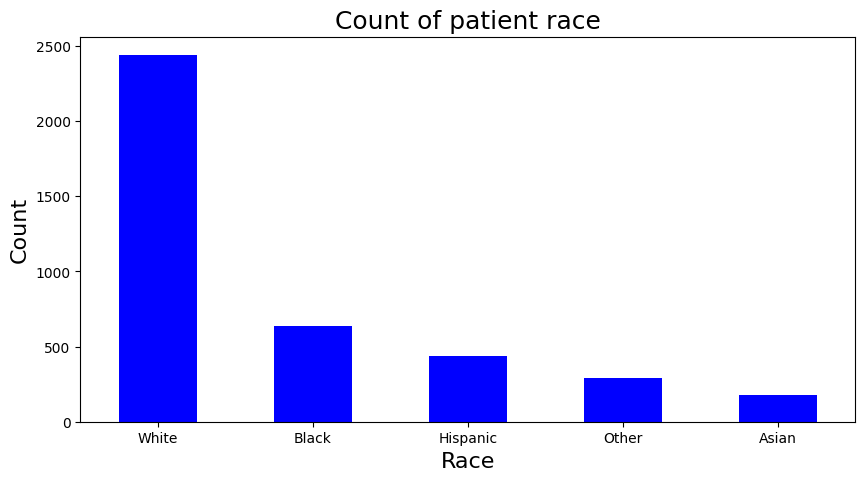

In [20]:
#compare race
plt.figure(figsize = (10,5))
train_data['patient_race'].value_counts().plot(kind='bar', color='blue')
plt.title('Count of patient race', fontsize=18)
plt.xlabel('Race', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(rotation=0)
plt.show()

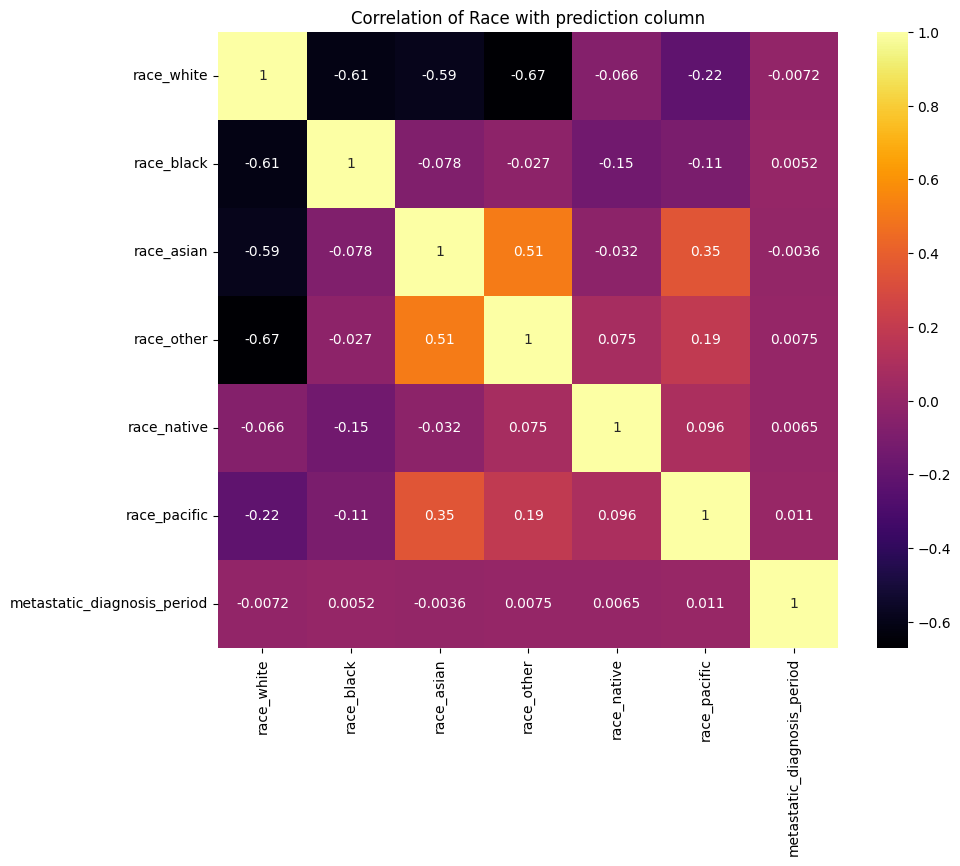

In [21]:
corr_matrix = train_data[['race_white','race_black','race_asian','race_other','race_native','race_pacific','metastatic_diagnosis_period']].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='inferno')
plt.title('Correlation of Race with prediction column')
plt.show()

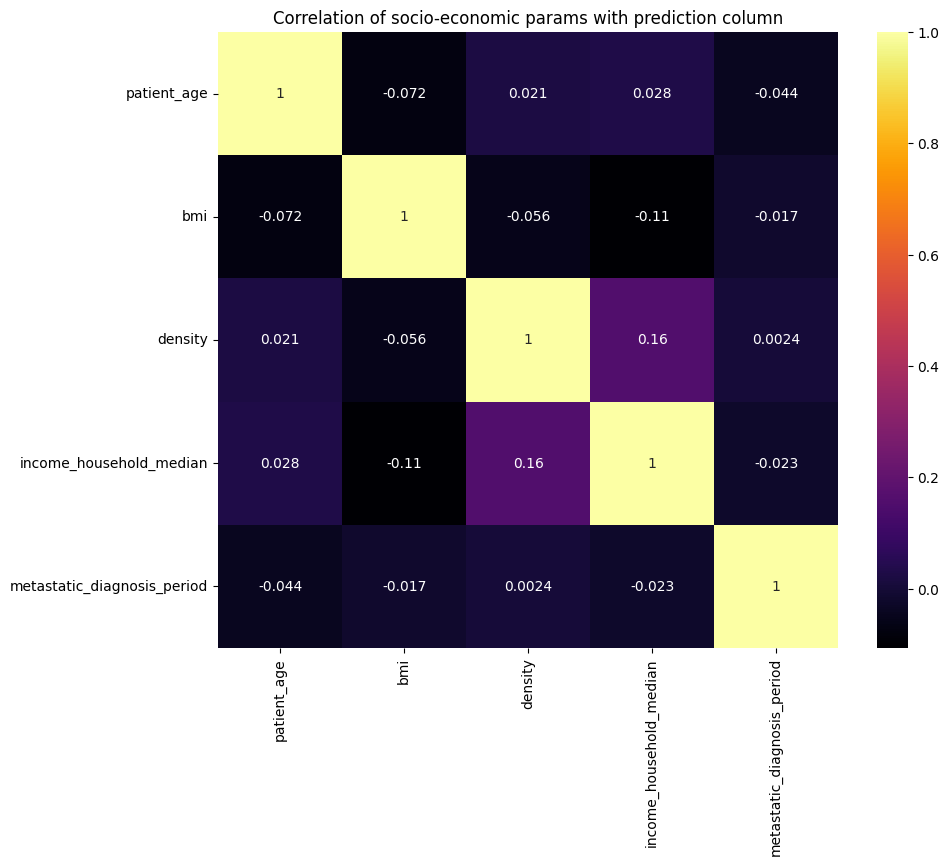

In [22]:
# Other correlation

corr_matrix = train_data[['patient_age','bmi','density','income_household_median','metastatic_diagnosis_period']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='inferno')
plt.title('Correlation of socio-economic params with prediction column')
plt.show()

In [23]:
## Being selective

In [24]:
# dropping certain columns that are not needed & separating the data
X = train_data.drop(['patient_id','patient_race','bmi','breast_cancer_diagnosis_desc','metastatic_diagnosis_period'],axis=1)
y = train_data['metastatic_diagnosis_period']

In [25]:
#print shape
print(X.shape, y.shape)

(3978, 145) (3978,)


In [26]:
X.head(5)

,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code,population,...,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18
1,COMMERCIAL,IL,629,Midwest,East North Central,3,F,C50412,C773,2745.39,...,44.18,49.30,72.87,77.40,77.43,75.83,72.64,58.36,39.68,39.71
6,MEDICARE ADVANTAGE,OH,448,Midwest,East North Central,3,F,C50412,C799,5890.57,...,34.44,42.62,65.91,71.26,74.03,73.94,69.12,53.50,36.43,34.10
7,COMMERCIAL,DE,198,South,South Atlantic,3,F,C50411,C792,22036.40,...,37.59,48.41,65.17,70.63,75.82,76.17,70.00,56.65,40.90,37.68
11,MEDICARE ADVANTAGE,OH,453,Midwest,East North Central,5,F,C50811,C773,6468.25,...,36.81,45.64,69.74,72.79,75.69,74.03,70.33,55.01,36.72,34.78
13,COMMERCIAL,MI,481,Midwest,East North Central,2,F,1749,C773,23266.06,...,32.92,39.93,63.56,68.68,72.13,72.55,66.17,49.79,34.16,32.28


In [27]:
y.head(5)

1      33
6      59
7     316
11     27
13    266
Name: metastatic_diagnosis_period, dtype: int64

In [28]:
numerical_cols = X.select_dtypes(exclude=['object']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

In [29]:
categorical_cols

Index(['payer_type', 'patient_state', 'Region', 'Division', 'patient_gender',
       'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code'],
      dtype='object')

In [30]:
## Handle Categorical Vals

In [31]:
# converting categorical feature to numerical feature
le_payer_type = LabelEncoder()
le_patient_state = LabelEncoder()
le_patient_zip3 = LabelEncoder()
le_region = LabelEncoder()
le_division = LabelEncoder()
le_breast_cancer = LabelEncoder()
le_metastatic_cancer = LabelEncoder()
le_patient_gender = LabelEncoder()

X['payer_type'] = le_payer_type.fit_transform(X['payer_type'])
X['patient_state'] = le_payer_type.fit_transform(X['patient_state'])
X['patient_zip3'] = le_payer_type.fit_transform(X['patient_zip3'])
X['Region'] = le_payer_type.fit_transform(X['Region'])
X['Division'] = le_payer_type.fit_transform(X['Division'])
X['breast_cancer_diagnosis_code'] = le_payer_type.fit_transform(X['breast_cancer_diagnosis_code'])
X['metastatic_cancer_diagnosis_code'] = le_payer_type.fit_transform(X['metastatic_cancer_diagnosis_code'])
X['patient_gender'] = le_payer_type.fit_transform(X['patient_gender'])

In [32]:
X.head(5)

,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code,population,...,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18
1,0,13,358,0,0,3,0,25,3,2745.39,...,44.18,49.30,72.87,77.40,77.43,75.83,72.64,58.36,39.68,39.71
6,2,30,248,0,0,3,0,25,36,5890.57,...,34.44,42.62,65.91,71.26,74.03,73.94,69.12,53.50,36.43,34.10
7,0,7,72,2,5,3,0,24,21,22036.40,...,37.59,48.41,65.17,70.63,75.82,76.17,70.00,56.65,40.90,37.68
11,2,30,253,0,0,5,0,33,3,6468.25,...,36.81,45.64,69.74,72.79,75.69,74.03,70.33,55.01,36.72,34.78
13,0,19,275,0,0,2,0,7,3,23266.06,...,32.92,39.93,63.56,68.68,72.13,72.55,66.17,49.79,34.16,32.28


In [33]:
# split data into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
print("train size : ", X_train.shape)
print("test size : ", X_test.shape)

train size :  (3182, 145)
test size :  (796, 145)


In [34]:
# Standardizing Data
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [35]:
# Random Forest
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

#fit to data
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [36]:
# get Imp features
feature_imp = rf.feature_importances_

In [37]:
#Sort feature imps
sorted_indices = feature_imp.argsort()[::-1]

In [38]:
sorted_indices

array([  7,   8,   5,   0,  47,  70,  54,  13,  12,  17,  16,  38,  50,
        24,  56,  15,  23,   2,  57,  20,  27,  30,  58,   4,  55,  44,
         9,  64,  71,  35,  37,  31,  36,  14,  72,  62,  33,  49,  34,
        26,  39,  32,  60,  69,  43,  48,  11,  18,  65,  59,  61,  21,
        25,  19,  22,  67, 129,  63,  10,  66,  52,  28, 127,  42,  51,
        79, 137, 105, 101, 116, 108,   1,  40, 138, 140,  92,  45,  68,
        46,  90, 141,  91, 115, 139,  80, 103,  98, 114,  53,  78, 128,
       102,  41, 126,  81, 104,  77, 111, 125,  89,  84,  86, 119,  73,
       133, 106, 117,  97, 131,  29,  75, 100, 124, 130,  99,  76, 135,
       142, 121, 123, 120, 113, 107,  95, 112,  93, 109, 122, 134,  96,
        94,  85, 143, 118,  82,  87, 110,  88,  74, 144, 132, 136,  83,
         3,   6], dtype=int64)

In [39]:
# selected features based in importance
no_features = 10
selected_features_indices = sorted_indices[:no_features]
selected_features = X_train.columns[selected_features_indices]

In [40]:
selected_features

Index(['breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code',
       'patient_age', 'payer_type', 'rent_burden', 'commute_time',
       'education_stem_degree', 'age_10_to_19', 'age_under_10', 'age_50s'],
      dtype='object')

In [41]:
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [42]:
rf.fit(X_train_selected, y_train)

# get accuracy
accuracy = rf.score(X_test_selected, y_test)

In [43]:
#Print features & accuracy 
print("Selected features - ",selected_features)
print("Accuracy - ",accuracy)

Selected features -  Index(['breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code',
       'patient_age', 'payer_type', 'rent_burden', 'commute_time',
       'education_stem_degree', 'age_10_to_19', 'age_under_10', 'age_50s'],
      dtype='object')
Accuracy -  0.34447777962266857


In [44]:
# RMSE for eval
def rmse(y_expect, y_pred):
    return np.sqrt(mean_squared_error(y_expect,y_pred))

In [45]:
rf_predict = rmse(y_test, rf.predict(X_test_selected))

In [46]:
rf_predict

89.24687041130657

In [47]:
#CatBoost
ctb = CatBoostRegressor( 
    random_state=42,
    learning_rate=0.02,
    verbose=False,
    cat_features=['patient_age'],
    eval_metric='RMSE'
).fit(X_train_selected, y_train, eval_set=(X_test_selected, y_test), use_best_model=True)

In [48]:
ctb_predict = rmse(y_test, ctb.predict(X_test_selected))

In [49]:
ctb_predict

81.70846275809565

In [50]:
#XGB
xgb = XGBRegressor(
    random_state=42,
    learning_rate=0.02,
    verbosity=0,
    eval_metric='rmse',
    tree_method='hist',  # Use 'hist' method for faster training,
    enable_categorical=True
).fit(X_train_selected, y_train, eval_set=[(X_test_selected, y_test)], early_stopping_rounds=10, verbose=False)

C:\Users\Hp\PycharmProjects\testpythonProject\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [51]:
xgb_predict = rmse(y_test, xgb.predict(X_test_selected))

In [52]:
xgb_predict

83.47099507020475

In [53]:
#LGBM
lgb = LGBMRegressor(
    random_state=42,
    learning_rate=0.02,
    metric='rmse',
    verbose=-1,
    early_stopping_rounds=10
).fit(X_train_selected, y_train, eval_set=[(X_test_selected, y_test)])

In [60]:
lgb_predict = rmse(y_test, lgb.predict(X_test_selected))

In [61]:
lgb_predict

83.43092392507383

In [63]:
#MLP
# Initialize MLPRegressor
mlp = MLPRegressor(
    random_state=42,
    learning_rate_init=0.02,
    max_iter=1000,
    early_stopping=True,
    validation_fraction=0.1,
    verbose=False
).fit(X_train_selected, y_train)

In [64]:
mlp_predict = rmse(y_test, mlp.predict(X_test_selected))

In [65]:
mlp_predict

83.44361335787423

In [ ]:
## Use the best model based on lowest RMSE to generate output file

In [54]:
# label Encoding for Test data
test_data['payer_type'] = le_payer_type.fit_transform(test_data['payer_type'])
test_data['patient_state'] = le_payer_type.fit_transform(test_data['patient_state'])
test_data['patient_zip3'] = le_payer_type.fit_transform(test_data['patient_zip3'])
test_data['Region'] = le_payer_type.fit_transform(test_data['Region'])
test_data['Division'] = le_payer_type.fit_transform(test_data['Division'])
test_data['breast_cancer_diagnosis_code'] = le_payer_type.fit_transform(test_data['breast_cancer_diagnosis_code'])
test_data['metastatic_cancer_diagnosis_code'] = le_payer_type.fit_transform(test_data['metastatic_cancer_diagnosis_code'])
test_data['patient_gender'] = le_payer_type.fit_transform(test_data['patient_gender'])

In [55]:
#selected feature
test_data_X = test_data[selected_features]

In [56]:
# Predict
test_data_result = ctb.predict(test_data_X)

In [57]:
# Update solution
solution_data['metastatic_diagnosis_period'] = test_data_result

In [58]:
solution_data.head(5)

,patient_id,metastatic_diagnosis_period
0,730681,209.909052
1,334212,66.351369
2,571362,195.280579
3,907331,211.735478
4,208382,59.400490


In [59]:
solution_data.to_csv("solution_ctb1.csv",index=False)